In [1]:
!pip install numpy matplotlib spacy nltk scikit-learn PyPDF2 python-docx pdf2image pytesseract Pillow tqdm

In [2]:
# Cell 1: Imports & setup
import os
import re
import glob
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity

import PyPDF2
import docx
from pdf2image import convert_from_path
import pytesseract
from PIL import Image

# Initialize spaCy and stopwords
nlp = spacy.load("en_core_web_md")
STOPWORDS = set(stopwords.words("english"))

# 🔹 Set your Tesseract path here
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Path to your dataset folder
RESUME_FOLDER = "DIGITAL-MEDIA"
TOP_N = 10


In [3]:
# Cell 2: Extract text from PDF/DOCX/TXT with OCR fallback
def extract_text_from_pdf(path):
    text = []
    try:
        with open(path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for page in reader.pages:
                page_text = page.extract_text()
                if page_text:
                    text.append(page_text)
    except Exception as e:
        print(f"Error reading {path}: {e}")

    # OCR fallback
    if not text or len("".join(text).strip()) == 0:
        print(f" OCR fallback for image-based PDF: {os.path.basename(path)}")
        try:
            images = convert_from_path(path, dpi=300)
            ocr_text = []
            for img in images:
                txt = pytesseract.image_to_string(img)
                ocr_text.append(txt)
            full_text = "\n".join(ocr_text)
            if len(full_text.strip()) > 0:
                print(f" OCR success for {os.path.basename(path)}")
            return full_text
        except Exception as e:
            print(f" OCR failed for {path}: {e}")
            return ""
    return "\n".join(text)

def extract_text_from_docx(path):
    doc = docx.Document(path)
    return "\n".join([p.text for p in doc.paragraphs if p.text])

def extract_text_from_txt(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def extract_text(path):
    ext = os.path.splitext(path)[1].lower()
    if ext == ".pdf":
        return extract_text_from_pdf(path)
    elif ext in [".docx", ".doc"]:
        return extract_text_from_docx(path)
    elif ext == ".txt":
        return extract_text_from_txt(path)
    else:
        return ""


In [4]:
# Cell 3: Clean text and lemmatize using spaCy
def clean_and_lemmatize(text):
    if not text:
        return ""
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()

    doc = nlp(text)
    lemmas = [
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop and token.lemma_ not in STOPWORDS
    ]
    return " ".join(lemmas)


In [5]:
# Cell 4: Get spaCy embedding and cosine similarity
def get_embedding(text):
    doc = nlp(text)
    return doc.vector

def cosine_sim(a, b):
    return cosine_similarity([a], [b])[0][0]


In [6]:
# Cell 5: Load all resumes and clean text
def load_resumes(folder):
    files = []
    for ext in ("*.pdf", "*.docx", "*.txt", "*.doc"):
        files.extend(glob.glob(os.path.join(folder, ext)))

    resumes = {}
    for f in tqdm(files, desc="Extracting resumes"):
        text = extract_text(f)
        if not text.strip():
            continue
        cleaned = clean_and_lemmatize(text)
        resumes[os.path.basename(f)] = {"raw": text, "clean": cleaned}
    return resumes


In [7]:
# Cell 6 (Updated): Smarter candidate name extraction
def extract_candidate_name(text):
    """
    Extract probable candidate name from resume text:
    - Prefers PERSON entities via spaCy
    - Ignores role/tech keywords (e.g., 'Python Developer', 'Full Stack')
    - Falls back to the first plausible name-like pattern
    """
    lines = [line.strip() for line in text.split("\n") if line.strip()]
    if not lines:
        return "Unknown"

    first_part = " ".join(lines[:10])  # analyze first few lines
    doc = nlp(first_part)

    # Try PERSON entities
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            name = ent.text.strip()
            if 2 <= len(name.split()) <= 3 and len(name) < 40:
                return name

    # Fallback: manually detect likely names (capitalized + no digits)
    potential = re.findall(r'\b[A-Z][a-z]{2,}\s[A-Z][a-z]{2,}\b', first_part)

    # Filter out common job-related terms
    blacklist = {"python", "developer", "engineer", "full", "stack",
                 "java", "django", "react", "analyst", "ml", "data"}
    for cand in potential:
        lower = cand.lower()
        if not any(word in lower for word in blacklist):
            return cand.strip()

    # Another fallback: use first capitalized word that’s not a job title
    caps = re.findall(r'\b[A-Z][a-z]+\b', first_part)
    for c in caps:
        if c.lower() not in blacklist and len(c) > 2:
            return c.strip()

    return "Unknown"


In [8]:
# Cell 7: Define Digital Media job description
job_description_text = """
We are hiring a Digital Media Specialist skilled in social media management, content creation,
SEO/SEM strategies, and online advertising (Google Ads, Meta Ads). Experience in analytics tools
like Google Analytics, social media insights, and campaign performance tracking is required.
Knowledge of digital branding, audience engagement, and marketing automation tools is a plus.
"""


In [9]:
# Cell 8: Rank resumes and show top candidates
def rank_resumes(job_description, resumes_dict, top_n=TOP_N):
    print("\nGenerating embeddings and ranking candidates...\n")
    job_clean = clean_and_lemmatize(job_description)
    job_vec = get_embedding(job_clean)

    scores = []
    for filename, data in tqdm(resumes_dict.items(), desc="Ranking"):
        candidate_name = extract_candidate_name(data["raw"])
        vec = get_embedding(data["clean"])
        score = cosine_sim(job_vec, vec)
        scores.append((candidate_name, filename, score))

    scores.sort(key=lambda x: x[2], reverse=True)

    print("\n=== Top Candidates ===")
    for i, (name, file, score) in enumerate(scores[:top_n], 1):
        print(f"{i}. {name} → {score:.4f}")

    # Visualization
    top_names = [x[0] for x in scores[:top_n]]
    top_scores = [x[2] for x in scores[:top_n]]
    plt.figure(figsize=(10, 5))
    plt.barh(top_names[::-1], top_scores[::-1])
    plt.title("Top DIGITAL-MEDIA Candidates")
    plt.xlabel("Cosine Similarity Score")
    plt.show()

    return scores


Extracting resumes: 100%|██████████| 96/96 [00:26<00:00,  3.58it/s]



Generating embeddings and ranking candidates...



Ranking: 100%|██████████| 96/96 [00:08<00:00, 11.54it/s]



=== Top Candidates ===
1. Career Focus → 0.9276
2. Summary Digital → 0.9226
3. Highlights Strong → 0.9162
4. Calvin Klein → 0.9159
5. Media Group → 0.9157
6. â€“ City → 0.9117
7. Highlights Dependable → 0.9094
8. Summary Digital → 0.9092
9. Summary Creative → 0.9092
10. Professional Overview → 0.9091


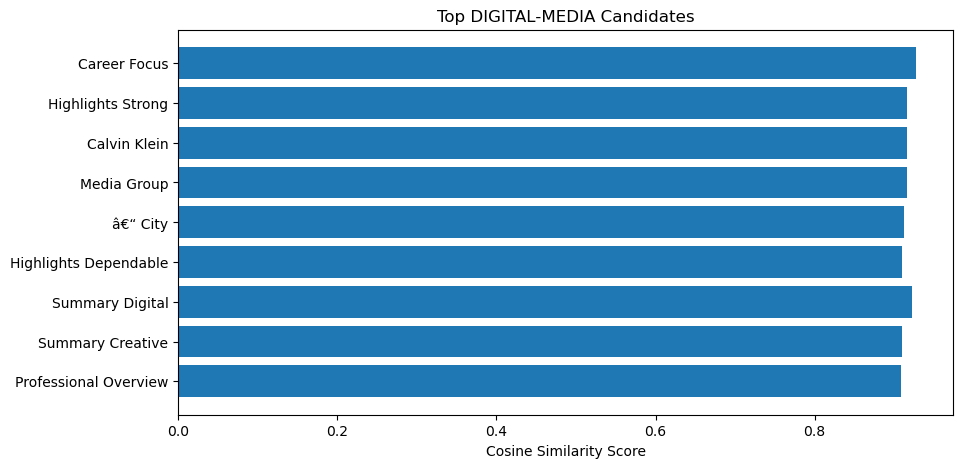

In [10]:
# Cell 9: Run everything and rank
resumes_dict = load_resumes(RESUME_FOLDER)
if not resumes_dict:
    print(" No extractable resumes found in folder!")
else:
    ranking = rank_resumes(job_description_text, resumes_dict, top_n=TOP_N)
